## Multi-output Regression with Neural Networks
- Start with base model (MLP using defaults from sklearn)
- Manually experiment with NN architectures & hyperparameter selections
- Use Keras Tuner algorithms then to find better solution

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from sklearn import preprocessing
from sklearn import datasets, linear_model, metrics
from sklearn import tree
from sklearn import datasets
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

!pip install -q -U keras-tuner
import tensorflow as tf
import keras_tuner as kt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load the data
#df_all = pd.read_csv('data/220306_slugs_dataset.csv')
df_all = pd.read_csv('/content/drive/MyDrive/_MScDA 2021/5. Data Mining 2/CA1/data/220306_slugs_dataset.csv')
df_inp = df_all.drop(['loadCase', 'out_supReac_kN_n3', 'out_supReac_kN_n4', 'out_verDisp_mm_n5'], axis=1)
df_inp = df_inp.dropna()

# Create some new features
df_inp['densDiff'] = df_inp['slugDen'] - df_inp['pockDen']
df_inp['centrFor'] = df_inp['slugVel']**2 * df_inp['densDiff']

## Data Scaling & Splitting

In [5]:
df_scl = df_inp.copy(deep=True)
scaler = preprocessing.StandardScaler() # Scale using standard deviation
df_scl = pd.DataFrame(scaler.fit_transform(df_scl), columns = df_scl.columns, index = df_scl.index)

# Create percentile field for sratification
df_scl['splits'] = pd.qcut(df_scl['out_oopDisp_mm_n2'], 100, labels=False)

# Create train and test splits (20% test)
train, test = train_test_split(df_scl, test_size=0.20, stratify=df_scl['splits'], random_state=0) 

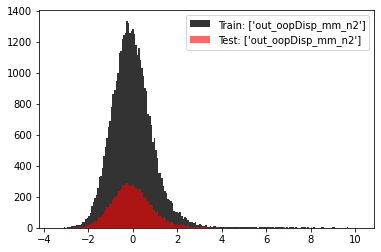

Max (train) =  10.2
Max (test) =  8.5


In [6]:
# Verify that stratification has been effective
n_bins = 200
param = ['out_oopDisp_mm_n2']
fig, axs = plt.subplots(figsize = (6, 4))
axs.hist(train[param].values, bins=n_bins, label = f'Train: {param}', color = 'black', alpha=0.8, zorder=1)
axs.hist(test[param].values, bins=n_bins, label = f'Test: {param}', color = 'red', alpha=0.6, zorder=2)
axs.legend(loc = 'upper right')
plt.show()
print('Max (train) = ', round(train[param].values.max(), 1))
print('Max (test) = ', round(test[param].values.max(), 1))

In [7]:
# Drop the splits column
train = train.drop(['splits'], axis=1)
test = test.drop(['splits'], axis=1)

In [8]:
pred_target = ['out_oopDisp_mm_n2', 'out_oopDisp_mm_n5', 'out_endBend_kNm_n6']
pred_features = [
    'slugDen',  # 0
    'slugLen',  # 1
    'pockDen',  # 2
    'pockLen',  # 3
    'slugVel',  # 4
    'basePer',  # 5
    'baseAmp',  # 6
    'basePha',  # 7
    'simTime',  # 8
    'densDiff', # 9
    'centrFor'  # 10
]
pred_features = pred_features[:]
X_train = train.filter(pred_features)
y_train = train.filter(pred_target)
X_test = test.filter(pred_features)
y_test = test.filter(pred_target)

## Base Model using MLP in Sklearn
- Using default model parameters.

In [ ]:
clf = MLPRegressor(random_state=1, max_iter=3000).fit(X_train.to_numpy(), y_train.to_numpy())
y_pred = clf.predict(X_test.to_numpy())

In [ ]:
y_bas = df_inp[pred_target].to_numpy()
scaler_m = preprocessing.StandardScaler()
y_scl = scaler_m.fit_transform(y_bas)

In [ ]:
# Inverse transform (scaling) to review metrics such as MAE
y = scaler_m.inverse_transform(y_test)
yhat = scaler_m.inverse_transform(y_pred)

for target in range(3):
    y_t = y[:, target]
    yhat_t = yhat[:, target]

    globals()[f'mae_momlp_{target}'] = metrics.mean_absolute_error(y_t, yhat_t)
    globals()[f'mse_momlp_{target}']  = metrics.mean_squared_error(y_t, yhat_t)
    globals()[f'rmse_momlp_{target}'] = np.sqrt(globals()[f'mse_momlp_{target}']) # or mse**(0.5)  
    r2 = metrics.r2_score(y_t, yhat_t)

    print(f'\nTarget {target+1}: Results of sklearn.metrics:')
    print("MAE:", round(globals()[f'mae_momlp_{target}'], 2))
    print("MSE:", round(globals()[f'mse_momlp_{target}'], 2))
    print("RMSE:", round(globals()[f'rmse_momlp_{target}'], 2))
    print("R-Squared:", round(r2, 2))


Target 1: Results of sklearn.metrics:
MAE: 5.16
MSE: 51.89
RMSE: 7.2
R-Squared: 0.94

Target 2: Results of sklearn.metrics:
MAE: 8.59
MSE: 144.1
RMSE: 12.0
R-Squared: 0.92

Target 3: Results of sklearn.metrics:
MAE: 14.57
MSE: 366.98
RMSE: 19.16
R-Squared: 0.89


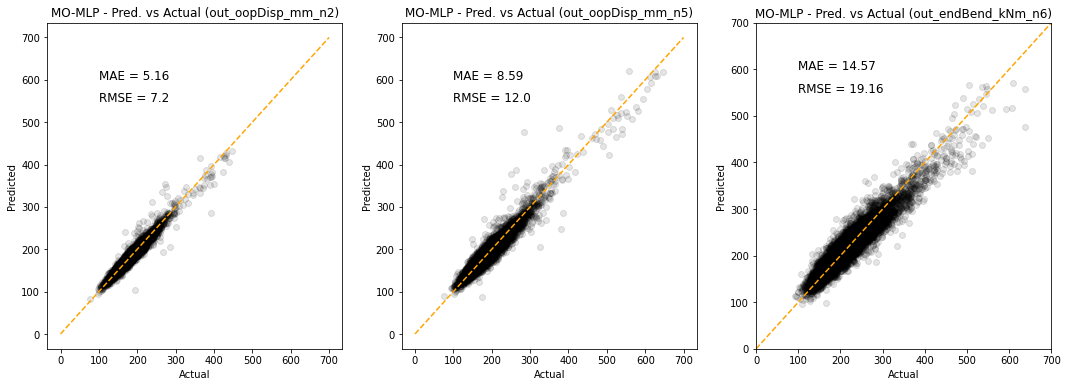

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6))

for p in range(3):
    mae = round(globals()[f'mae_momlp_{p}'], 2)
    rmse = round(globals()[f'rmse_momlp_{p}'], 2)
    ax[p].scatter(y[:, p], yhat[:, p], color = 'black', zorder = 1, alpha=0.1)
    ax[p].plot([0, 700], [0, 700], '--', color = 'orange', zorder = 2)
    ax[p].set(ylabel = 'Predicted', xlabel = 'Actual')
    ax[p].set_title(f'MO-MLP - Pred. vs Actual ({pred_target[p]})')
    ax[p].text(100, 600, f'MAE = {round(mae, 2)}', fontsize = 12)
    ax[p].text(100, 550, f'RMSE = {round(rmse, 2)}', fontsize = 12)

plt.xlim(0, 700)
plt.ylim(0, 700)

plt.show()

## NN Model Experiments

In [ ]:
# Manually select architecture & hyperparameters
def gen_model1(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(256, input_dim=n_inputs, activation='relu'))
    model.add(Dropout(.4))
    model.add(Dense(512, activation='relu'))   
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))    
    model.add(Dense(n_outputs, activation='linear'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model2(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model3(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(100, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model4(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(80, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model5(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(60, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model6(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(80, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(40, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model7(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(80, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(40, kernel_initializer='he_uniform', activation='tanh'))
    model.add(Dense(9, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model8(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(80, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(40, kernel_initializer='he_uniform', activation='tanh'))
    model.add(Dense(9, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model9(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(80, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu')) 
    model.add(Dense(40, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(9, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model10(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(50, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model11(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(80, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(40, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.008)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model12(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(80, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(40, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.002)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model13(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(80, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(40, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model14(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(90, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(30, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.002)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model15(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(76, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(38, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.002)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model16(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(162, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(106, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

In [9]:
# Create a function to run a model, calculation & plot metrics
def run_model(model_num, track=False, verb_out=0):
    # Generate the model
    n_inputs, n_outputs = X_train.to_numpy().shape[1], y_train.to_numpy().shape[1]
    gen_model = globals()[f'gen_model{model_num}']
    nn_model = gen_model(n_inputs, n_outputs)
    if track: model_track.append(model_num)

    # Fit the model
    history = nn_model.fit(X_train.to_numpy(), y_train.to_numpy(), epochs=300, batch_size=128, validation_split=0.20, verbose=verb_out).history

    # Plot the training losses
    fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
    ax.plot(history['loss'], 'grey', label='Train', linewidth=2)
    ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
    ax.set_title('Model loss', fontsize=16)
    ax.set_ylabel('Loss (mae)')
    ax.set_xlabel('Epoch')
    ax.legend(loc='upper right')
    plt.show()

    # Make predictions on test data
    y_pred = nn_model.predict(X_test.to_numpy())
    y_bas = df_inp[pred_target].to_numpy()
    scaler_m = preprocessing.StandardScaler()
    y_scl = scaler_m.fit_transform(y_bas)

    # Inverse transform (scaling) to review metrics such as MAE
    y = scaler_m.inverse_transform(y_test)
    yhat = scaler_m.inverse_transform(y_pred)

    # Collect predictions for return
    y_1, y_2, y_3 = ([], [], [])
    yhat_1, yhat_2, yhat_3 = ([], [], [])

    # Print metrics
    for target in range(3):
        y_t = y[:, target]
        yhat_t = yhat[:, target]
     
        # Append y and yhat for return
        if target == 0:
            y_1.append(y_t)
            yhat_1.append(yhat_t)
        elif target == 1:
            y_2.append(y_t)
            yhat_2.append(yhat_t)
        elif target == 2:
            y_3.append(y_t)
            yhat_3.append(yhat_t)      

        globals()[f'mae_momlp_{target}'] = metrics.mean_absolute_error(y_t, yhat_t)
        globals()[f'mse_momlp_{target}']  = metrics.mean_squared_error(y_t, yhat_t)
        globals()[f'rmse_momlp_{target}'] = np.sqrt(globals()[f'mse_momlp_{target}']) # or mse**(0.5)  
        r2 = metrics.r2_score(y_t, yhat_t)

        print(f'\nTarget {target+1}: Results of sklearn.metrics:')
        print("MAE:", round(globals()[f'mae_momlp_{target}'], 2))
        print("MSE:", round(globals()[f'mse_momlp_{target}'], 2))
        print("RMSE:", round(globals()[f'rmse_momlp_{target}'], 2))
        print("R-Squared:", round(r2, 2))
        if track: globals()[f'mae_track{target+1}'].append(round(globals()[f'mae_momlp_{target}'], 2))
        if track: globals()[f'rmse_track{target+1}'].append(round(globals()[f'rmse_momlp_{target}'], 2))

    # Plot performance
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    for p in range(3):
        mae = round(globals()[f'mae_momlp_{p}'], 2)
        rmse = round(globals()[f'rmse_momlp_{p}'], 2)
        ax[p].scatter(y[:, p], yhat[:, p], color = 'black', zorder = 1, alpha=0.1)
        ax[p].plot([0, 700], [0, 700], '--', color = 'orange', zorder = 2)
        ax[p].set(ylabel = 'Predicted', xlabel = 'Actual')
        ax[p].set_title(f'MO-NN - Pred. vs Actual ({pred_target[p]})')
        ax[p].text(100, 600, f'MAE = {round(mae, 2)}', fontsize = 12)
        ax[p].text(100, 550, f'RMSE = {round(rmse, 2)}', fontsize = 12)

    plt.xlim(0, 700)
    plt.ylim(0, 700)
    plt.show()

    # Model predictions dataframe summary
    df = pd.DataFrame(data=list(y_1[0].ravel()), columns=['y_1'])
    df['y_2'] = list(y_2[0].ravel())
    df['y_3'] = list(y_3[0].ravel())
    df['yhat_1'] = list(yhat_1[0].ravel())
    df['yhat_2'] = list(yhat_2[0].ravel())
    df['yhat_3'] = list(yhat_3[0].ravel())

    # Add error calcs including percentage error for later MAPE evaluation
    df = df.assign(
        error_1 = lambda x: x['yhat_1'] - x['y_1'],
        error_2 = lambda x: x['yhat_2'] - x['y_2'],
        error_3 = lambda x: x['yhat_3'] - x['y_3'],
        abs_error_1 = lambda x: x['error_1'].abs(),
        abs_error_2 = lambda x: x['error_2'].abs(),
        abs_error_3 = lambda x: x['error_3'].abs(),
        p_error_1 = lambda x: 100*(x['error_1'].div(x['y_1'])),
        p_error_2 = lambda x: 100*(x['error_2'].div(x['y_2'])),
        p_error_3 = lambda x: 100*(x['error_3'].div(x['y_3']))
    )

    return(df, nn_model)

  0%|          | 0/11 [00:00<?, ?it/s]

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 80)                960       
                                                                 
 dense_19 (Dense)            (None, 40)                3240      
                                                                 
 dense_20 (Dense)            (None, 3)                 123       
                                                                 
Total params: 4,323
Trainable params: 4,323
Non-trainable params: 0
_________________________________________________________________
None


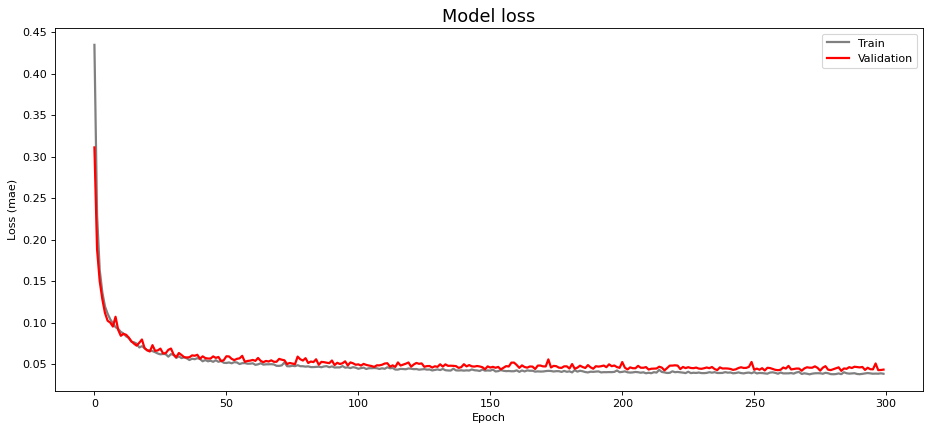


Target 1: Results of sklearn.metrics:
MAE: 4.2
MSE: 33.46
RMSE: 5.78
R-Squared: 0.96

Target 2: Results of sklearn.metrics:
MAE: 6.6
MSE: 85.4
RMSE: 9.24
R-Squared: 0.96

Target 3: Results of sklearn.metrics:
MAE: 11.05
MSE: 212.18
RMSE: 14.57
R-Squared: 0.94


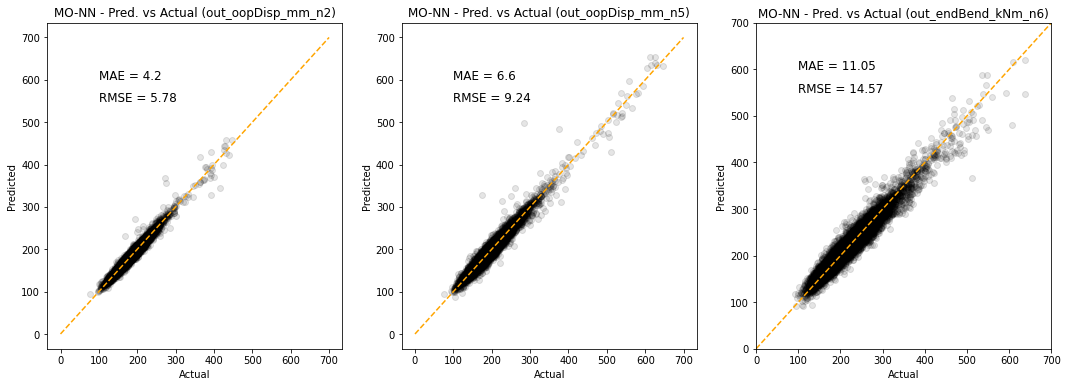

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 80)                960       
                                                                 
 dense_22 (Dense)            (None, 40)                3240      
                                                                 
 dense_23 (Dense)            (None, 9)                 369       
                                                                 
 dense_24 (Dense)            (None, 3)                 30        
                                                                 
Total params: 4,599
Trainable params: 4,599
Non-trainable params: 0
_________________________________________________________________
None


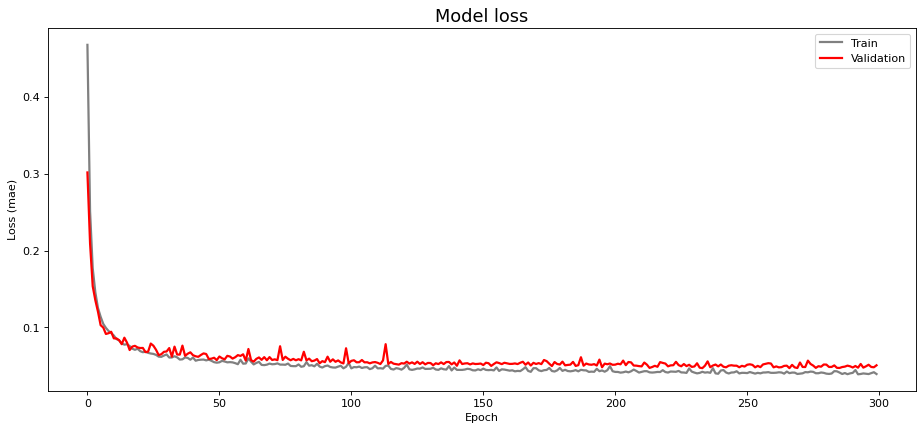


Target 1: Results of sklearn.metrics:
MAE: 4.29
MSE: 34.61
RMSE: 5.88
R-Squared: 0.96

Target 2: Results of sklearn.metrics:
MAE: 6.83
MSE: 91.39
RMSE: 9.56
R-Squared: 0.95

Target 3: Results of sklearn.metrics:
MAE: 11.21
MSE: 227.75
RMSE: 15.09
R-Squared: 0.93


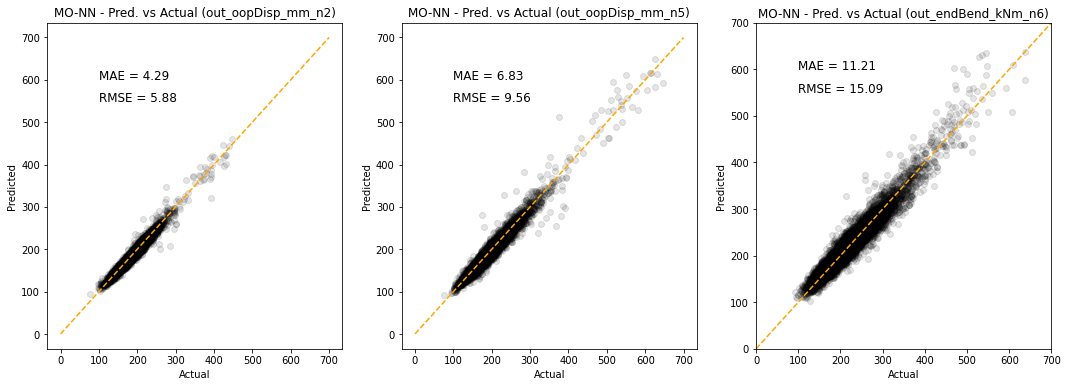

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 80)                960       
                                                                 
 dense_26 (Dense)            (None, 40)                3240      
                                                                 
 dense_27 (Dense)            (None, 9)                 369       
                                                                 
 dense_28 (Dense)            (None, 3)                 30        
                                                                 
Total params: 4,599
Trainable params: 4,599
Non-trainable params: 0
_________________________________________________________________
None


Exception ignored in: <function tqdm.__del__ at 0x7fa78f90b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/usr/local/lib/python3.7/dist-packages/tqdm/notebook.py", line 287, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


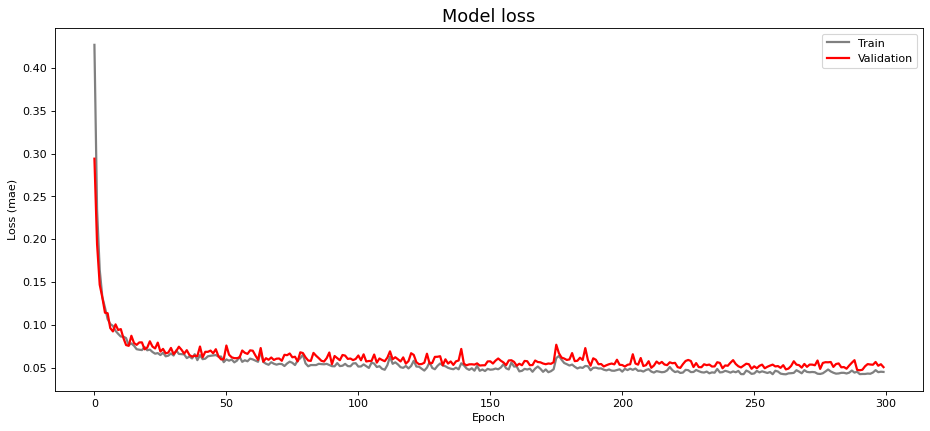


Target 1: Results of sklearn.metrics:
MAE: 4.6
MSE: 45.39
RMSE: 6.74
R-Squared: 0.95

Target 2: Results of sklearn.metrics:
MAE: 7.03
MSE: 106.18
RMSE: 10.3
R-Squared: 0.94

Target 3: Results of sklearn.metrics:
MAE: 11.42
MSE: 233.71
RMSE: 15.29
R-Squared: 0.93


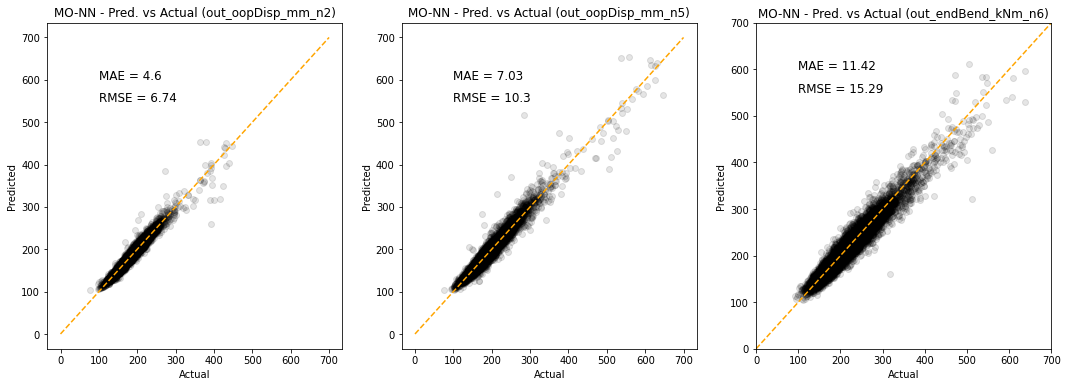

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 80)                960       
                                                                 
 dense_30 (Dense)            (None, 40)                3240      
                                                                 
 dense_31 (Dense)            (None, 9)                 369       
                                                                 
 dense_32 (Dense)            (None, 3)                 30        
                                                                 
Total params: 4,599
Trainable params: 4,599
Non-trainable params: 0
_________________________________________________________________
None


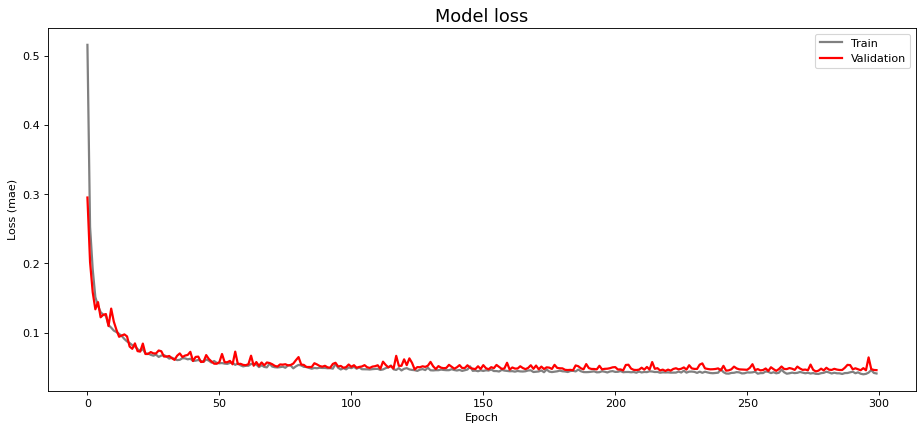


Target 1: Results of sklearn.metrics:
MAE: 4.11
MSE: 31.84
RMSE: 5.64
R-Squared: 0.97

Target 2: Results of sklearn.metrics:
MAE: 6.66
MSE: 85.22
RMSE: 9.23
R-Squared: 0.96

Target 3: Results of sklearn.metrics:
MAE: 11.46
MSE: 230.66
RMSE: 15.19
R-Squared: 0.93


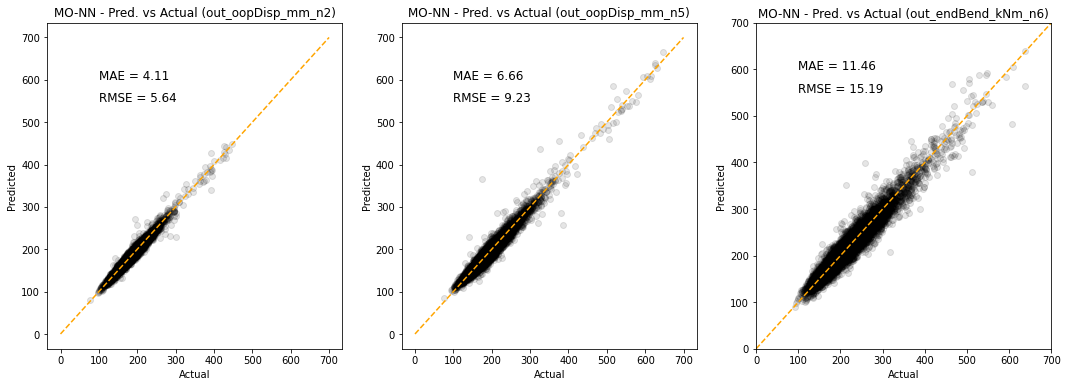

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 50)                600       
                                                                 
 dense_34 (Dense)            (None, 3)                 153       
                                                                 
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________
None


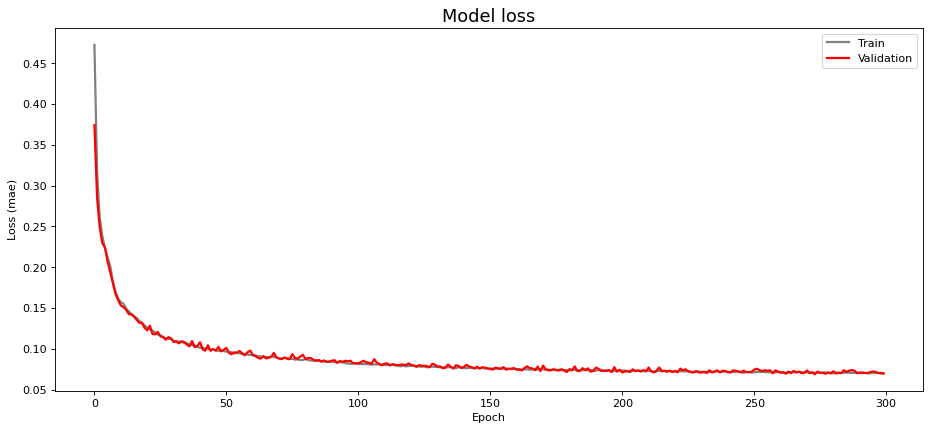


Target 1: Results of sklearn.metrics:
MAE: 4.89
MSE: 44.18
RMSE: 6.65
R-Squared: 0.95

Target 2: Results of sklearn.metrics:
MAE: 8.23
MSE: 123.78
RMSE: 11.13
R-Squared: 0.93

Target 3: Results of sklearn.metrics:
MAE: 14.07
MSE: 344.63
RMSE: 18.56
R-Squared: 0.9


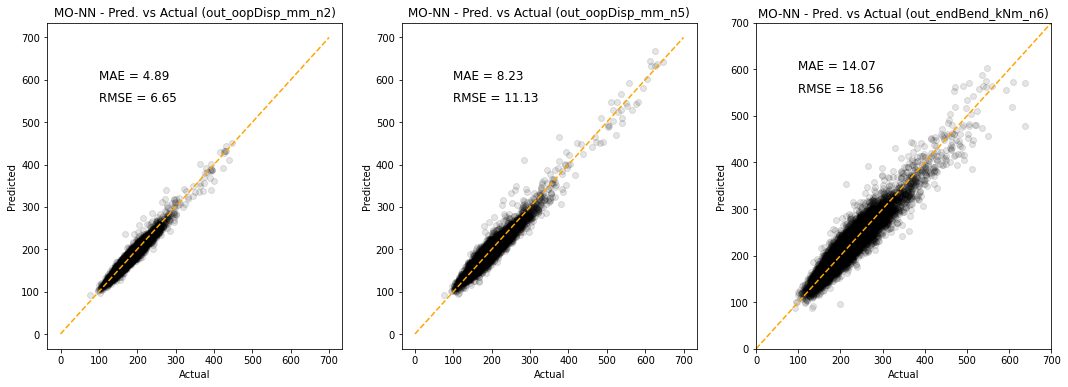

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 80)                960       
                                                                 
 dense_36 (Dense)            (None, 40)                3240      
                                                                 
 dense_37 (Dense)            (None, 3)                 123       
                                                                 
Total params: 4,323
Trainable params: 4,323
Non-trainable params: 0
_________________________________________________________________
None


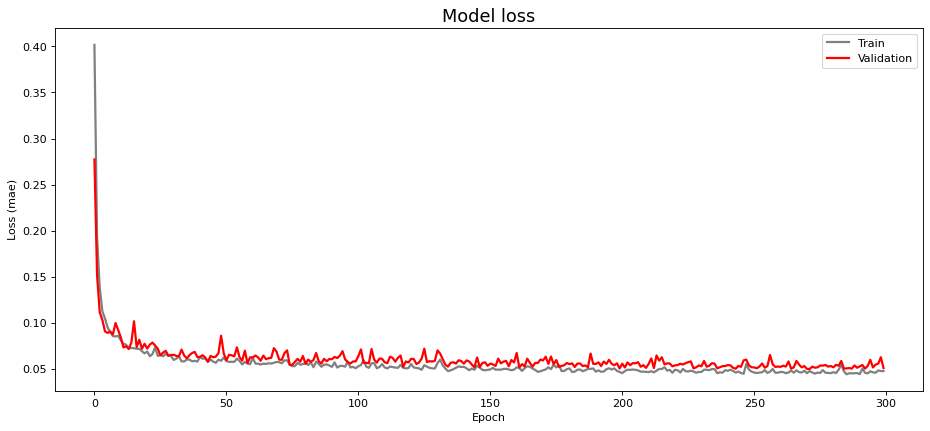


Target 1: Results of sklearn.metrics:
MAE: 4.46
MSE: 38.38
RMSE: 6.2
R-Squared: 0.96

Target 2: Results of sklearn.metrics:
MAE: 7.03
MSE: 98.79
RMSE: 9.94
R-Squared: 0.95

Target 3: Results of sklearn.metrics:
MAE: 11.36
MSE: 229.96
RMSE: 15.16
R-Squared: 0.93


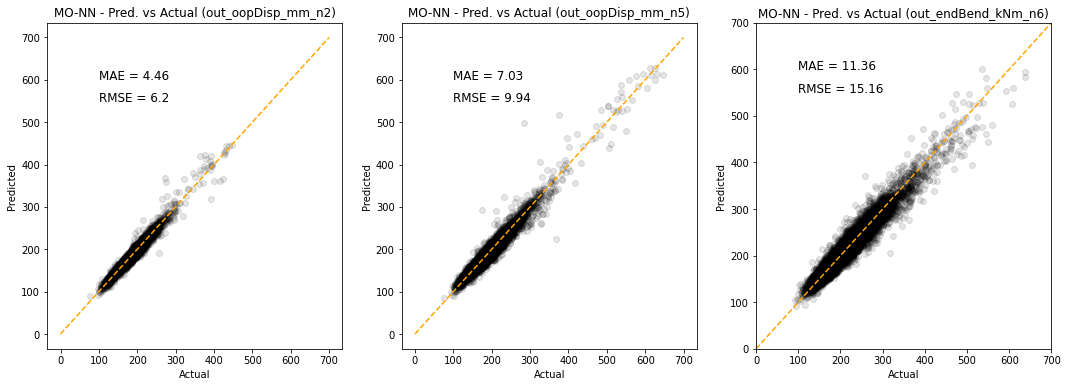

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 80)                960       
                                                                 
 dense_39 (Dense)            (None, 40)                3240      
                                                                 
 dense_40 (Dense)            (None, 3)                 123       
                                                                 
Total params: 4,323
Trainable params: 4,323
Non-trainable params: 0
_________________________________________________________________
None


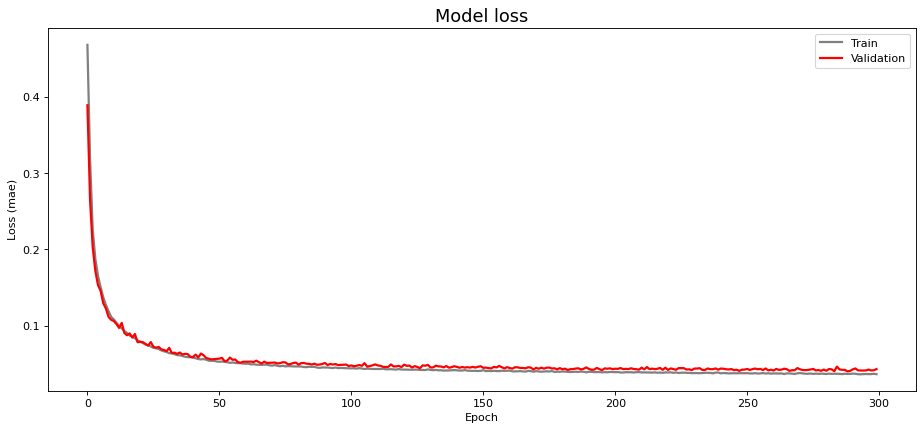


Target 1: Results of sklearn.metrics:
MAE: 4.11
MSE: 31.72
RMSE: 5.63
R-Squared: 0.97

Target 2: Results of sklearn.metrics:
MAE: 6.6
MSE: 81.05
RMSE: 9.0
R-Squared: 0.96

Target 3: Results of sklearn.metrics:
MAE: 11.06
MSE: 212.01
RMSE: 14.56
R-Squared: 0.94


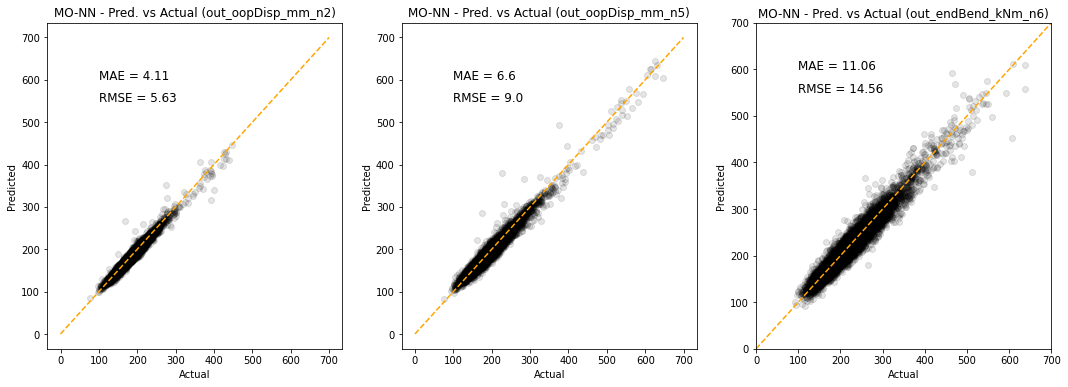

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 80)                960       
                                                                 
 dense_42 (Dense)            (None, 40)                3240      
                                                                 
 dense_43 (Dense)            (None, 3)                 123       
                                                                 
Total params: 4,323
Trainable params: 4,323
Non-trainable params: 0
_________________________________________________________________
None


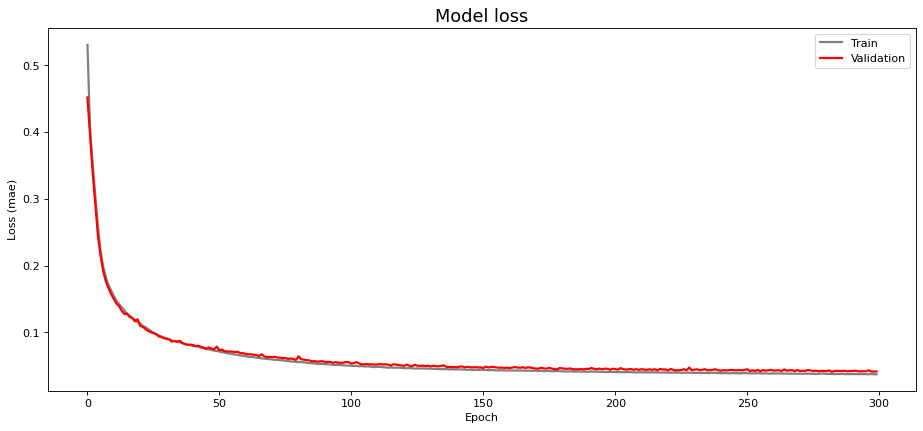


Target 1: Results of sklearn.metrics:
MAE: 3.94
MSE: 28.37
RMSE: 5.33
R-Squared: 0.97

Target 2: Results of sklearn.metrics:
MAE: 6.19
MSE: 71.56
RMSE: 8.46
R-Squared: 0.96

Target 3: Results of sklearn.metrics:
MAE: 11.07
MSE: 217.34
RMSE: 14.74
R-Squared: 0.94


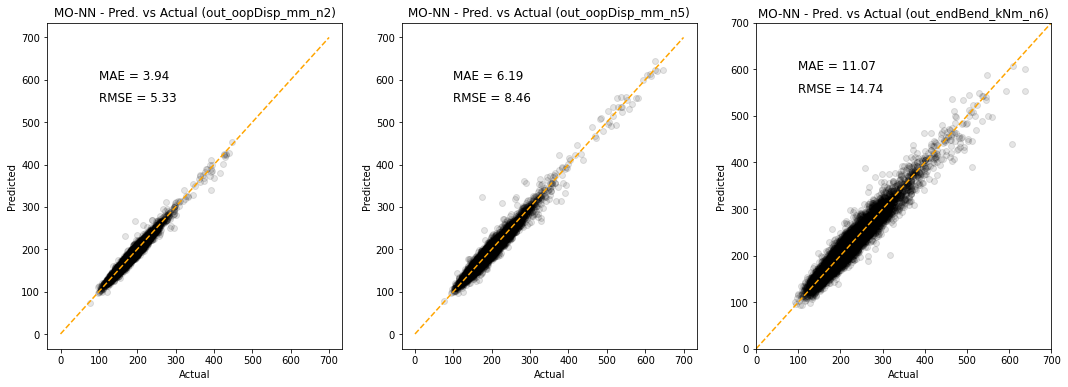

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 90)                1080      
                                                                 
 dense_45 (Dense)            (None, 30)                2730      
                                                                 
 dense_46 (Dense)            (None, 3)                 93        
                                                                 
Total params: 3,903
Trainable params: 3,903
Non-trainable params: 0
_________________________________________________________________
None


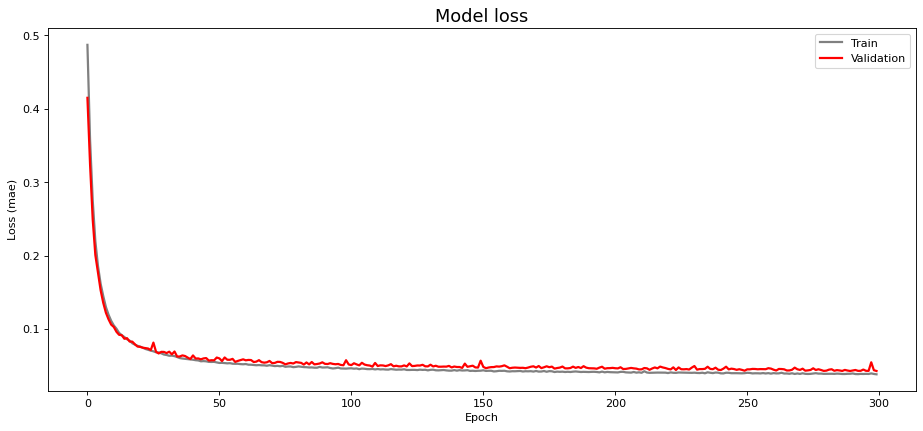


Target 1: Results of sklearn.metrics:
MAE: 3.98
MSE: 29.43
RMSE: 5.43
R-Squared: 0.97

Target 2: Results of sklearn.metrics:
MAE: 6.28
MSE: 74.42
RMSE: 8.63
R-Squared: 0.96

Target 3: Results of sklearn.metrics:
MAE: 11.31
MSE: 226.21
RMSE: 15.04
R-Squared: 0.93


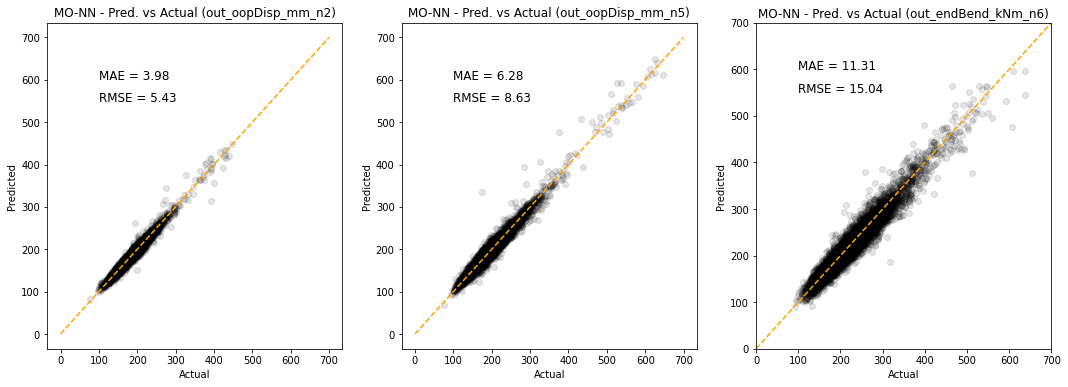

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_47 (Dense)            (None, 76)                912       
                                                                 
 dense_48 (Dense)            (None, 38)                2926      
                                                                 
 dense_49 (Dense)            (None, 3)                 117       
                                                                 
Total params: 3,955
Trainable params: 3,955
Non-trainable params: 0
_________________________________________________________________
None


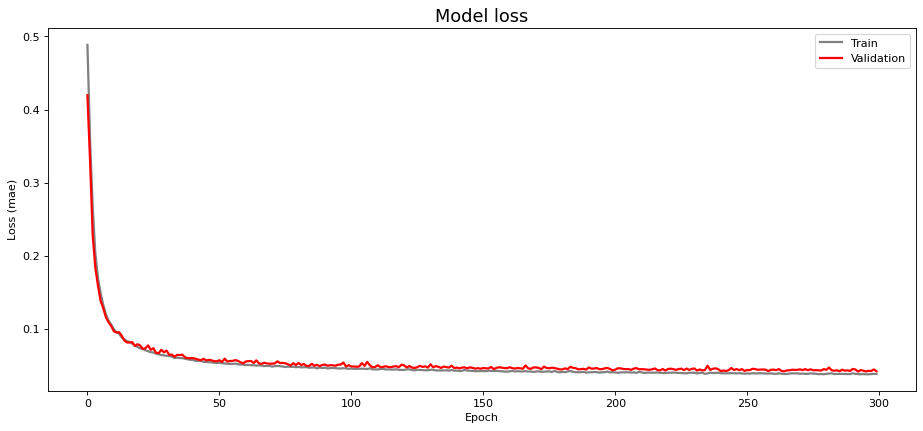


Target 1: Results of sklearn.metrics:
MAE: 3.97
MSE: 30.5
RMSE: 5.52
R-Squared: 0.97

Target 2: Results of sklearn.metrics:
MAE: 6.26
MSE: 75.48
RMSE: 8.69
R-Squared: 0.96

Target 3: Results of sklearn.metrics:
MAE: 10.98
MSE: 217.54
RMSE: 14.75
R-Squared: 0.94


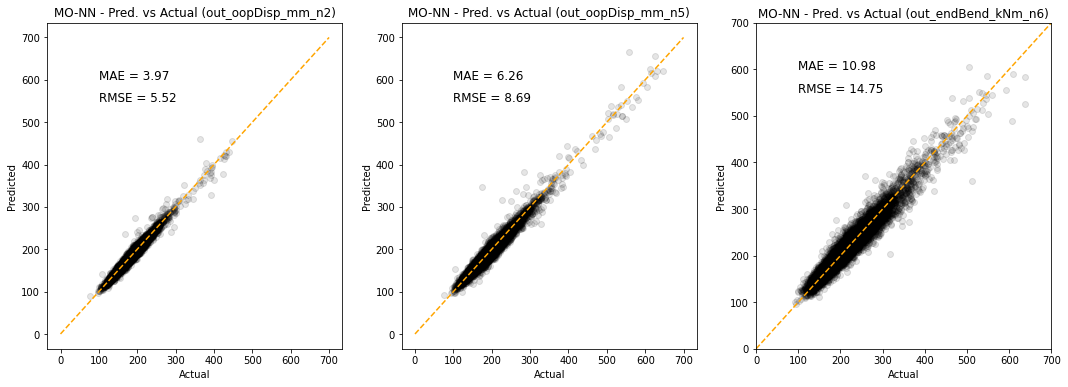

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 162)               1944      
                                                                 
 dense_51 (Dense)            (None, 106)               17278     
                                                                 
 dense_52 (Dense)            (None, 3)                 321       
                                                                 
Total params: 19,543
Trainable params: 19,543
Non-trainable params: 0
_________________________________________________________________
None


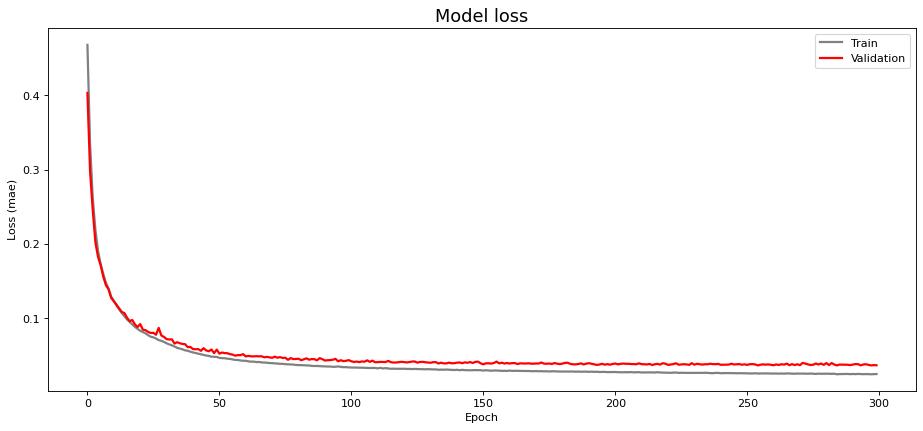


Target 1: Results of sklearn.metrics:
MAE: 3.83
MSE: 27.19
RMSE: 5.21
R-Squared: 0.97

Target 2: Results of sklearn.metrics:
MAE: 6.19
MSE: 73.05
RMSE: 8.55
R-Squared: 0.96

Target 3: Results of sklearn.metrics:
MAE: 10.22
MSE: 190.01
RMSE: 13.78
R-Squared: 0.95


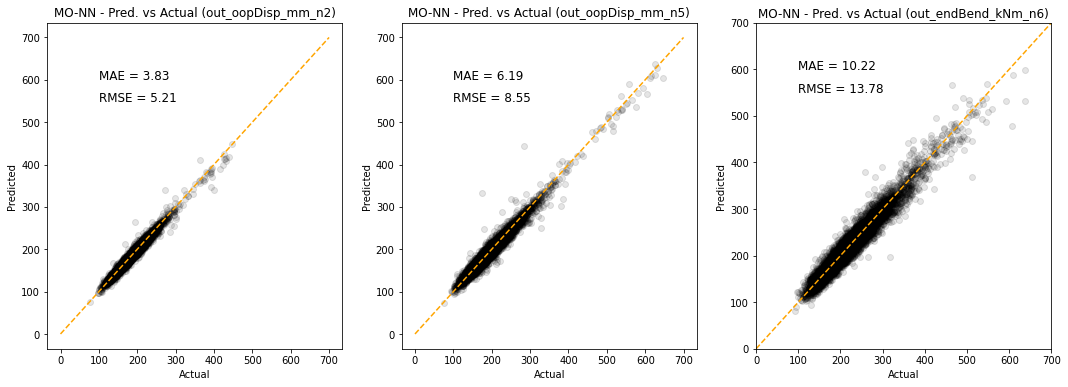

In [ ]:
# Loop through and fit each model and collect performance results.
model_track = []
mae_track1, mae_track2, mae_track3 = ([], [], [])
rmse_track1, rmse_track2, rmse_track3 = ([], [], [])
for m_num  in tqdm(range(5, 16, 1)):
    model_num = m_num + 1
    run_model(model_num, track=True, verb_out=0)

In [ ]:
# Model tracking dataframe summary
experiments = pd.DataFrame(data=model_track, columns=['model_ref'])
experiments['mae1'] = mae_track1
experiments['mae2'] = mae_track2
experiments['mae3'] = mae_track3
experiments['rmse1'] = rmse_track1
experiments['rmse2'] = rmse_track2
experiments['rmse3'] = rmse_track3
experiments

,model_ref,mae1,mae2,mae3,rmse1,rmse2,rmse3
0,6,4.20,6.60,11.05,5.78,9.24,14.57
1,7,4.29,6.83,11.21,5.88,9.56,15.09
2,8,4.60,7.03,11.42,6.74,10.30,15.29
3,9,4.11,6.66,11.46,5.64,9.23,15.19
4,10,4.89,8.23,14.07,6.65,11.13,18.56
5,11,4.46,7.03,11.36,6.20,9.94,15.16
6,12,4.11,6.60,11.06,5.63,9.00,14.56
7,13,3.94,6.19,11.07,5.33,8.46,14.74
8,14,3.98,6.28,11.31,5.43,8.63,15.04
9,15,3.97,6.26,10.98,5.52,8.69,14.75


## Hyperparameter Tuning using Keras Tuner

In [35]:
def hp_model_builder(hp):
    n_inputs, n_outputs = X_train.to_numpy().shape[1], y_train.to_numpy().shape[1]
    model = Sequential()
    
    # Tune the number of units in the two Dense layers
    hp_units1 = hp.Int('units_h1', min_value=30, max_value=240, step=4)
    hp_units2 = hp.Int('units_h2', min_value=10, max_value=160, step=4)

    # Tune whether to use dropout on visible input layer.
    if hp.Boolean("dropout_visible"):
        model.add(Dropout(0.2, input_shape=(n_inputs,)))
        model.add(Dense(units=hp_units1, kernel_initializer='he_uniform', activation='tanh'))
    else:
        model.add(Dense(units=hp_units1, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh'))   
    
    if hp.Boolean("dropout_hidden"): model.add(Dropout(0.2))
    model.add(Dense(units=hp_units2, kernel_initializer='he_uniform', activation='tanh')) 
    if hp.Boolean("dropout_hidden"): model.add(Dropout(0.2))
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from list
    hp_learning_rate = hp.Choice('learning_rate', values=[0.1, 0.01, 0.05, 0.001, 0.002, 0.005, 0.0001])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='mse')
    return model

### a) Hyperband Optimizer

In [39]:
tuner = kt.Hyperband(
    hp_model_builder,
    objective='val_loss',
    max_epochs=300,
    factor=3,
    # Remove overwrite and use dirs to save each runs to file.
    overwrite=True
    #directory='work_dir',
    #project_name='kt_tuner_proj'
    )

In [40]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [1]:
#tuner.search(X_train.to_numpy(), y_train.to_numpy(), epochs=300, validation_split=0.20, callbacks=[stop_early])

In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units_h1')} and for the 2nd layer is {best_hps.get('units_h2')}. The the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 86 and for the 2nd layer is 154. The the optimal learning rate for the optimizer
is 0.001.



### b) Bayesian Optimizer

In [ ]:
bo_tuner = kt.BayesianOptimization(
    hp_model_builder,
    objective='val_loss',
    max_trials=50,
    seed=0,
    overwrite=True
    )
bo_tuner.search(X_train.to_numpy(), y_train.to_numpy(), epochs=150, validation_split=0.20, callbacks=[stop_early])

Trial 5 Complete [00h 05m 22s]
val_loss: 0.13276652991771698

Best val_loss So Far: 0.06298889964818954
Total elapsed time: 00h 19m 32s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the optimal hyperparameters
best_bo_hps=bo_tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_bo_hps.get('units_h1')} and for the 2nd layer is {best_hps.get('units_h2')}. The the optimal learning rate for the optimizer
is {best_bo_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 238 and for the 2nd layer is 154. The the optimal learning rate for the optimizer
is 0.0001.



### Run Best Models from Tuning & Review Performance

In [10]:
def gen_model101(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(86, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(154, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

def gen_model102(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(238, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(154, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 86)                1032      
                                                                 
 dense_1 (Dense)             (None, 154)               13398     
                                                                 
 dense_2 (Dense)             (None, 3)                 465       
                                                                 
Total params: 14,895
Trainable params: 14,895
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/300
250/250 [==============================] - 1s 3ms/step - loss: 0.4742 - val_loss: 0.4083
Epoch 2/300
250/250 [==============================] - 1s 3ms/step - loss: 0.3651 - val_loss: 0.3557
Epoch 3/300
250/250 [==============================] - 1s 3ms/step - loss: 0.3080 - val_loss: 0.2874
Epoch 4/

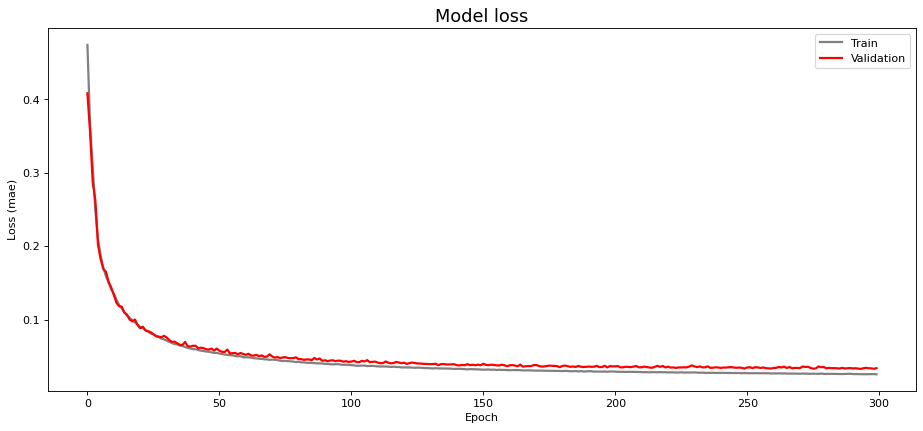


Target 1: Results of sklearn.metrics:
MAE: 3.59
MSE: 23.59
RMSE: 4.86
R-Squared: 0.97

Target 2: Results of sklearn.metrics:
MAE: 5.72
MSE: 62.46
RMSE: 7.9
R-Squared: 0.97

Target 3: Results of sklearn.metrics:
MAE: 9.84
MSE: 174.13
RMSE: 13.2
R-Squared: 0.95


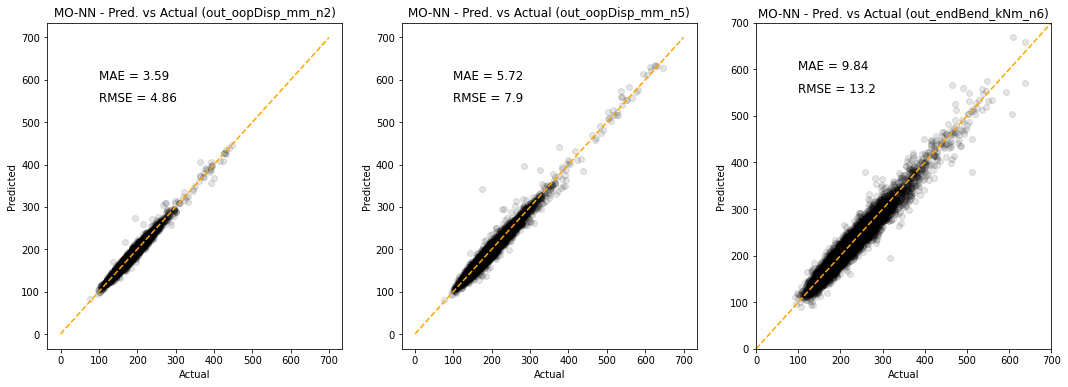

In [11]:
# Model suggested from Hyperband optimizer
out_101, model_101 = run_model(101, verb_out=1)

In [12]:
# Compute Errors Metrics.
df = out_101
"""
MAPE is commonly used to measure forecasting errors, but it can be deceiving when values reach
numbers close to zero. WAPE is a measure that counters this by weighting the error over totals. 
"""
for param in range(1, 4, 1):
    globals()[f'mape_{param}'] = round(df[f'p_error_{param}'].abs().mean(), 2)
    globals()[f'wape_{param}'] = round(100*(df[f'error_{param}'].abs().sum() / df[f'y_{param}'].abs().sum()), 2)

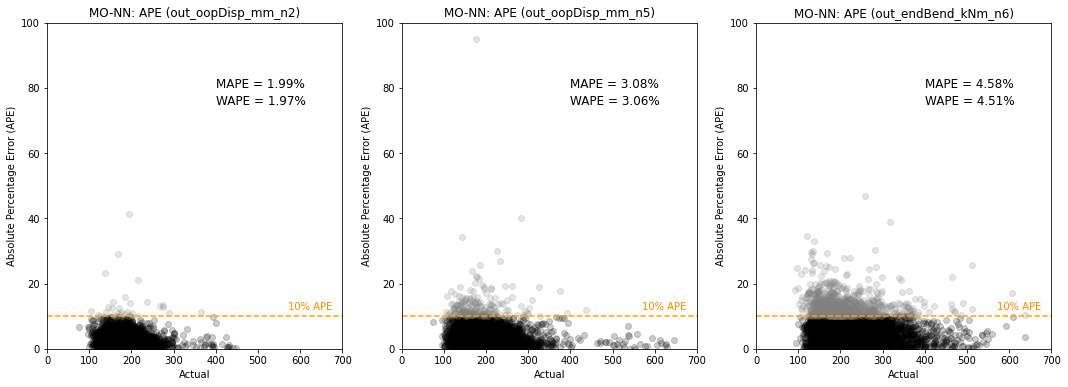

In [13]:
# Plot absolute percentage error (APE) and further evaluate performance
fig, ax = plt.subplots(1, 3, figsize = (18, 6))
for p in range(3):
    mape = globals()[f'mape_{p+1}']
    wape = globals()[f'wape_{p+1}']
    df_plot = df.sort_values([f'y_{p+1}'], ascending=True)
    df_plot_below = df_plot.loc[(df[f'p_error_{p+1}'].abs() <= 10), :]
    df_plot_above = df_plot.loc[(df[f'p_error_{p+1}'].abs() > 10), :]
    ax[p].scatter(df_plot_below[f'y_{p+1}'], df_plot_below[f'p_error_{p+1}'].abs(), color = 'black', zorder = 1, alpha=0.2)
    ax[p].scatter(df_plot_above[f'y_{p+1}'], df_plot_above[f'p_error_{p+1}'].abs(), color = 'grey', zorder = 2, alpha=0.2)
    ax[p].text(570, 12, '10% APE', fontsize = 10, color = 'darkorange')
    ax[p].plot([0, 700], [10, 10], '--', color = 'orange', zorder = 2)
    ax[p].set(ylabel = 'Absolute Percentage Error (APE)', xlabel = 'Actual')
    ax[p].text(400, 80, f'MAPE = {round(mape, 2)}%', fontsize = 12)
    ax[p].text(400, 75, f'WAPE = {round(wape, 2)}%', fontsize = 12)
    ax[p].set_ylim(0, 100)
    ax[p].set_xlim(0, 700)
    ax[p].set_title(f'MO-NN: APE ({pred_target[p]})') 
plt.show()

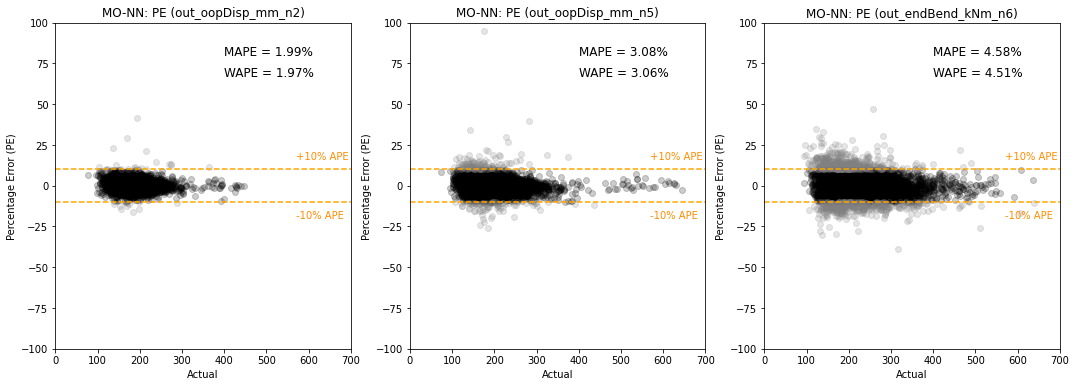

In [22]:
# Plot percentage error (PE) and further evaluate performance
fig, ax = plt.subplots(1, 3, figsize = (18, 6))
for p in range(3):
    mape = globals()[f'mape_{p+1}']
    wape = globals()[f'wape_{p+1}']
    df_plot = df.sort_values([f'y_{p+1}'], ascending=True)
    df_plot_below = df_plot.loc[(df[f'p_error_{p+1}'].abs() <= 10), :]
    df_plot_above = df_plot.loc[(df[f'p_error_{p+1}'].abs() > 10), :]
    ax[p].scatter(df_plot_below[f'y_{p+1}'], df_plot_below[f'p_error_{p+1}'], color = 'black', zorder = 1, alpha=0.2)
    ax[p].scatter(df_plot_above[f'y_{p+1}'], df_plot_above[f'p_error_{p+1}'], color = 'grey', zorder = 2, alpha=0.2)
    ax[p].text(570, 16, '+10% APE', fontsize = 10, color = 'darkorange')
    ax[p].plot([0, 700], [10, 10], '--', color = 'orange', zorder = 2)
    ax[p].text(570, -20, '-10% APE', fontsize = 10, color = 'darkorange')
    ax[p].plot([0, 700], [-10, -10], '--', color = 'orange', zorder = 2)
    ax[p].set(ylabel = 'Percentage Error (PE)', xlabel = 'Actual')
    ax[p].text(400, 80, f'MAPE = {round(mape, 2)}%', fontsize = 12)
    ax[p].text(400, 67, f'WAPE = {round(wape, 2)}%', fontsize = 12)
    ax[p].set_ylim(-100, 100)
    ax[p].set_xlim(0, 700)
    ax[p].set_title(f'MO-NN: PE ({pred_target[p]})') 
plt.show()

## Feature Attributions: SHAP (SHapley Additive exPlanations)
Use SHAP to get an understanding of features that are driving the model.

In [23]:
!pip install shap
import shap
# print the JS visualization code to the notebook
shap.initjs()

     |████████████████████████████████| 564 kB 8.4 MB/s 


In [24]:
explainer = shap.KernelExplainer(model = model_101.predict, data = X_train.head(50), link = "identity")

In [26]:
# Start with first 50 training examples
shap_values = explainer.shap_values(X = X_train.iloc[0:50,:], nsamples = 100)

  0%|          | 0/50 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Parameter: out_oopDisp_mm_n2



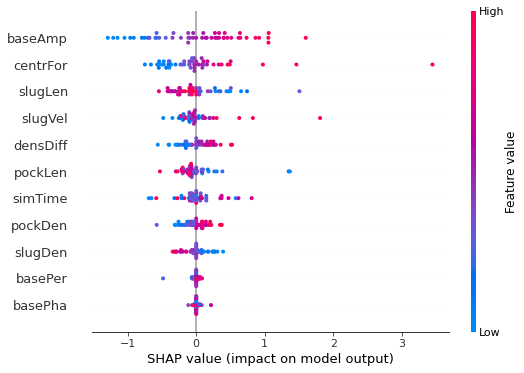



Parameter: out_oopDisp_mm_n5



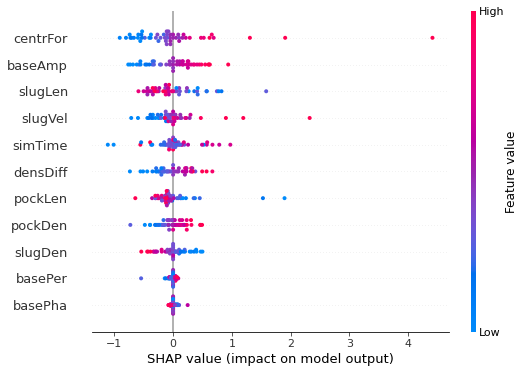



Parameter: out_endBend_kNm_n6



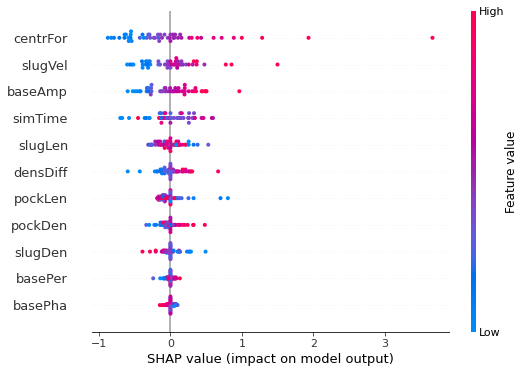

In [37]:
# Create a visualisation of parameters that are driving model predictions
# Red will be increasing output
# Blue will be decreasing output
shap.initjs()
# Reminder of target parameters
# pred_target = ['out_oopDisp_mm_n2', 'out_oopDisp_mm_n5', 'out_endBend_kNm_n6']

# Loop through and plot for each target parameter the SHAP value plot
for shap_param in range(3):
    select_param = pred_target[shap_param]
    print(f'Parameter: {select_param}\n')
    shap.summary_plot(shap_values = shap_values[shap_param], features = X_train.iloc[0:50,:]) 
    print(f'\n')

The above makes sense and is line expectation / domain concepts. Centrifugal force is expected to drive out-of-plane response. Base amplitude period and phase angle would not be expected to drive response.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 238)               2856      
                                                                 
 dense_4 (Dense)             (None, 154)               36806     
                                                                 
 dense_5 (Dense)             (None, 3)                 465       
                                                                 
Total params: 40,127
Trainable params: 40,127
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/300
250/250 [==============================] - 2s 6ms/step - loss: 0.4437 - val_loss: 0.3761
Epoch 2/300
250/250 [==============================] - 1s 6ms/step - loss: 0.3128 - val_loss: 0.2715
Epoch 3/300
250/250 [==============================] - 1s 6ms/step - loss: 0.2353 - val_loss: 0.2126
Epoch 

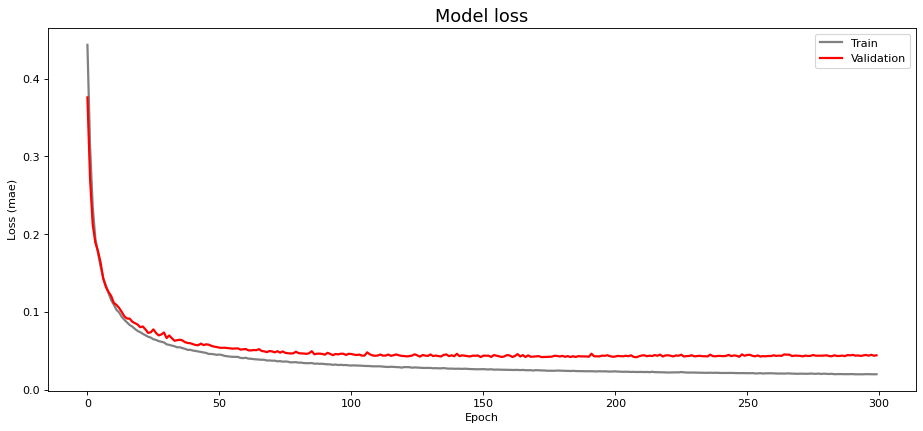


Target 1: Results of sklearn.metrics:
MAE: 4.01
MSE: 30.86
RMSE: 5.56
R-Squared: 0.97

Target 2: Results of sklearn.metrics:
MAE: 6.6
MSE: 86.85
RMSE: 9.32
R-Squared: 0.95

Target 3: Results of sklearn.metrics:
MAE: 10.88
MSE: 212.94
RMSE: 14.59
R-Squared: 0.94


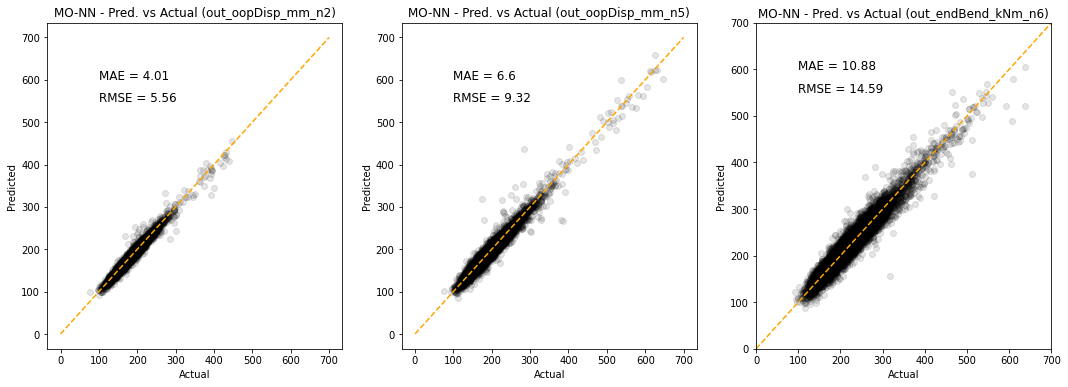

In [ ]:
# Model suggestin from Bayesian optimizer
run_model(102, verb_out=1)